In [4]:
%pylab
%matplotlib inline
import healpy as hp
import time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy.coordinates import AltAz
from astropy.time import TimeDelta
from astropy.coordinates import get_sun
from functools import reduce

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


### Frequency extrapolation

In [5]:
T_Hmap = hp.read_map("lambda_haslam408_dsds.fits")  # read_map loads the first column

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/Users/michellemora/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


    Temperature spectral index
    
$$\alpha=-\frac{log(T_1/T_2)}{log(\nu_1/\nu_2)}$$

In [6]:
def T_freq(alpha,freq1,freq2,T1):
    return T1*10**(alpha*log10(freq1/freq2))

### Galactic longitude (l) and latitude (b)

In [145]:
nside = hp.get_nside(T_Hmap)  #nside
npix = hp.nside2npix(nside)   #number of pixels

l, b = hp.pix2ang(nside, arange(npix), lonlat=True)   #(l, b) coordinates for each pixel
g_coord=SkyCoord(l*u.deg, b*u.deg, frame='galactic')  

### Time and location for horizontal coordinates 

In [146]:
Alma_loc = EarthLocation.of_site('ALMA')
start_t=Time('2021-06-14T00:00:00',format='isot')

times30=start_t + TimeDelta(30*60, format='sec')*linspace(0,48,48) #dt=30 min

altaz30 = AltAz(location=Alma_loc, obstime=times30)

### Dynamic Spectra

Temperature matrix for the dynamic spectra

$$T(\nu,t)=\begin{pmatrix}
T(\nu_1,t_m) & T(\nu_2,t_m) & \cdots & T(\nu_n,t_m)\\ 
 \vdots &  \vdots  &\vdots & \vdots  \\ 
T(\nu_1,t_1) & T(\nu_2,t_1) & \cdots & T(\nu_n,t_1)
\end{pmatrix}$$

In [108]:
freqs1=arange(40,111,1)

### Antenna gain

In [140]:
g_cols=loadtxt('Gain_Blade_nominal_Raul_phi_0.dat',skiprows=2,usecols=arange(1,72))
g_phi0=g_cols[90:]
Theta=arange(0,91,1)

### Script for the observations

In [141]:
def Temps_gain(fs,ts):  
    '''Takes frequencies (fs) and times in AltAz frame (ts) and returns the 
       Temperature and Gain matrix'''
    
    start = time.time()
    Temps=zeros((ts.obstime.size,len(fs)))
    Gains=zeros((ts.obstime.size,len(fs))) 
    
    for i in range (ts.obstime.size):
        aa_coord=g_coord.transform_to(ts[i])      #Galactic to Altaz
        mask=argwhere(aa_coord.alt>0)             #Only coordinates above the horizon
        T_sky=T_Hmap[mask]                        #Only those temperatures
        
        Th=((90*u.deg-(aa_coord.alt[mask]))/(1*u.deg))    ##Thetas to use
        
        for j in range (len(fs)):
            T_f=T_freq(2.54,408,fs[j],T_sky)      #Extrapolation
            Temps[-i,j]=mean(T_f)                 #Mean temperature (bottom to top)
            
            gs=g_phi0[Th.value.astype(int),j]     ##Gains for Th to use and freq_j
            Gains[-i,j]=mean(gs)                  ##Mean gain (bottom to top)
            
            
    end = time.time()
    print('Tiempo recorrido(s):',end - start)  
    return Temps,Gains

In [142]:
T,G=Temps_gain(freqs1,altaz30)

Tiempo recorrido(s): 290.72297406196594


In [150]:
T_G=T*G   #Dynamic Spectra + Gain pattern

Text(0.5,0,'freq (MHz)')

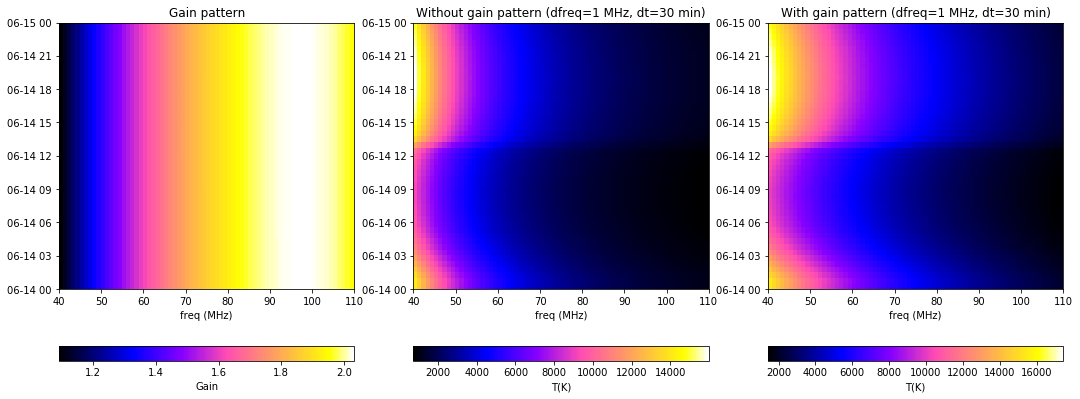

In [152]:
figure(figsize=(18,7))
subplot(1,3,1)
pcolormesh(freqs1,times30.to_datetime(), G,cmap='gnuplot2')
colorbar(label='Gain',orientation="horizontal")
title("Gain pattern"),xlabel('freq (MHz)')
subplot(1,3,2)
pcolormesh(freqs1,times30.to_datetime(), T,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("Without gain pattern (dfreq=1 MHz, dt=30 min)"),xlabel('freq (MHz)')
subplot(1,3,3)
pcolormesh(freqs1,times30.to_datetime(), T_G,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("With gain pattern (dfreq=1 MHz, dt=30 min)")
xlabel('freq (MHz)')